# University of Aberdeen

## Applied AI (CS5079)

### Assessment 1 - Asterix

#### Part 1
---

Reinforcement Learning from the Screen Frames

###1.1) Imports and Environment set up
---
This step takes care of all the necessary imports for the flawless execution of the first task. 
We will be using the standard lbiraries used for machine learning, and statistical/mathematical analysis and plotting.


In [ ]:
import tensorflow as tf
import numpy as np
import random
from math import sqrt
from statistics import mean
import os
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

[1337, 17452119]


The next step is game initialization. As we are using OpenAI to implement our model, we will import the OpenAI Gym module and load the Asterix game. As this is a Reinforcement Learning experiment, the team values empiricism and reproducibility, so we make use of randomness by calling <b>env.seed()</b>.


In [ ]:
import gym
env = gym.make("Asterix-v0")
env.seed(1337)

###*Observing the environment*
---
Our next task is the description of the environment. This includes observation space, which outputs the enviornment type and dimensions.

We need action space as this is used to define the characterstics of the environment action space.

We then take a quick look at rewards, the environment's info dictionary and episode.


In [ ]:
print("Observation space:", env.observation_space)
print("Action space:", env.action_space)
print("Possible actions:", env.unwrapped.get_action_meanings())
print('Info dictionary:', env.step(action)[3])
print('Reward:', env.step(action)[1])

Observation space: Box(210, 160, 3)
Action space: Discrete(9)
Possible actions: ['NOOP', 'UP', 'RIGHT', 'LEFT', 'DOWN', 'UPRIGHT', 'UPLEFT', 'DOWNRIGHT', 'DOWNLEFT']



Observations: `env.observation_space` shows that the obseravtion space is an **RGB** image of which is an array of shape **(210, 160, 3)**, indicating a height of 210 pixels, a width of 160 pixels and 3 channels.  <br />  <br /> 
Action Space: `env.action_space` shows us that the action space is **discrete** with **9 possible actions** that are printed out for better understanding using `env.unwrapped.get_action_meanings()`. Each action is performed repeatedly for a duration of ***k*** frames, where ***k*** is sampled from the set {2,3,4} uniformly. The discrete space allows for a fixed range of non-negative numbers, where low (`env.observation_space.low`) will be a grid filled with zeros (**0x0x0**) and high (`env.observation_space.high`) will be a grid filled with **250x250x250**. <br /> <br /> 
Reward: **0** but is accumulated as an episode is played and the player collects cauldrons and items giving him points. <br /> <br /> 
Environment's info dictionary: The info dictionary contains `ale.lives()` which refers to the number of lives left. In our case, the player has **only 3 lives** that decrease as he collides with the lyres <br /> <br /> 
Episode: An episode is concluded when the player loses a life. When a game is played and **done** is equal to **True**, this indicates that the game is finished and the player has lost all lives. <br /> <br /> 

To display this, a simple agent that performs random actions for one episode is implemented.



In [ ]:
class RandomAgent():
    def __init__(self, env):
        self.action_size = env.action_space.n
        
    def get_action(self, observation):
        return random.choice(range(self.action_size))
    
total_reward=0
agent = RandomAgent(env)
numberOfEpisodes = 1
 
for steps in range(numberOfEpisodes):
     current_obs = env.reset()
     done = False
     while not done:
         action = agent.get_action(current_obs)
         next_obs, reward, done, info = env.step(action)
         total_reward += reward
         env.render()
print("Average reward: {}".format(total_reward/numberOfEpisodes))

#### 1.2) Q Learning
---

Q Learning is a Reinforcement Learning technique used to determine the optimal policy in Markov Decision Processes. It uses a Q-Table which is a ***m x n*** lookup table, where ***m=states*** and ***n=actions***, used for the calculation of the maximum expected future reward for action at each state.

Each score in the Q-Table will be the maximum expected future reward for that specific action at that specific state. To calculate these values, we use the Q-function. Under a given policy $\pi$, the true value of an action ***a*** in a state ***s*** is 

![equation](https://miro.medium.com/max/1400/1*6IqzImIFK1oEiVWmlu1Esw.png)

where $\gamma \in [0,1]$ is a discount factor that performs the immediate and later rewards importance trade-off.

The Q-function can identify an optimal action-selection policy given any finite Markov decision process and return the expected rewards for an action taken in a given state. It is estimated using Q-learning which iteratively updates ***Q(state,action)*** using the Bellman Equation.

To make sure that there is balance between exploring states and exploiting rewards, we will be using an epsilon greedy strategy 

![equation](https://miro.medium.com/max/1400/1*9StLEbor62FUDSoRwxyJrg.png)


As Asterix is a game where an agent moves around stage lines in order to collect rewards and avoid being killed, we can classify it as a good environment for Reinforcement Learning as there are states, opportunities for the player to learn a control policy through actions, and scalar rewards. And we can utilise the Q-function as our game has episodes.


#### 1.2) Deep Q-Learning

As games become more complex, the efficiency of producing and updating a Q-table can become lower and lower, especially when dealing with bigger state space environments. To optimize Q-Learning, we can replace the Q-table with a Deep Q Neural Network (DQN).


![equation](https://knowledge.dataiku.com/latest/_images/illustration-73.jpg)

The DQN will have frames as input and a vector of Q-values for each possible action in the given state as output. The biggest Q-value of this vector is considered for the best action.

The concept of a DQN can apply to and solve complex problems and environments. It is capable of taking actions that it has not seen before.

To avoid the possibility of a big Q-table and memory issues, we will implement a DQN for Asterix, which can be more time consuming but also more efficient.

#### 1.3) Pre-processing

---

We are using a special wrapper for the purpose of environment preprocessing. 

This reshapes the image to .... and the agent will receive a grayscale observation as we have converted the observarions to grayscale. We also scale all observations to [0,1].

Another common preprocessing step is the introductioon of frame skipping (Naddaf, 2010 at https://era.library.ualberta.ca/items/a661eb66-f2e0-4ed3-b501-b6cbcd1fdd9d), which is what restricts the agent's decision points by repeating some selected action for ***k*** consequitve frames, making the RL problem simpler and speeding up execution. 

This notebook follows an approach where the agent is designed with a richer observation space by combining past frames with most recent ones ask nown as frame stacking (Mnih et al., 2015 https://www.nature.com/articles/nature14236). We use 4 frames, but the algorithm might also be robust with different values such as 3 or 5. Due to time concerns, this notebook did not have the ability to experiment with such values.

This actually reduces the degree of partial observability, making it possible for the agnet to detect the direction of motion in game objects. Due to this reduction in partial observability, the agent can detect the direction of motion of objects in the game.



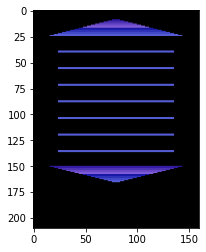

float32


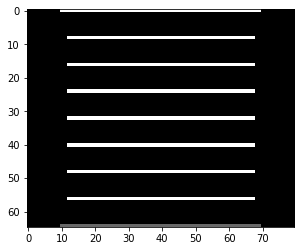

In [ ]:
obs = env.reset()
from skimage.color import rgb2gray

def preprocess_observation(observation):
    img = observation[23:153:2, ::2] # This becomes 90, 80, 3
#     print(img.shape)
#     print(img.shape)
#     img = img.mean(axis=2) #to grayscale (values between 0 and 255)
    img = rgb2gray(img)
    img = img.astype(np.float32) # normalize from -128 to 127
    return img.reshape(65, 80, 1)

plt.imshow(obs)
plt.show()
print(preprocess_observation(obs)[0].dtype)
plt.imshow(preprocess_observation(obs).reshape(65,80), cmap='gray')
plt.show()

1.4. Create a function `q_network` that (1) takes as input a variable of shape $(96,80,1)$, (2) creates a deep convolutional network with 3 convolutional hidden layers and two dense layers, and (3) returns the output layer and the trainable variables in a dictionary where the keys are the name of the variables.

In [ ]:
# Import the Keras layer used for building our models
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D,\
MaxPool2D, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

INPUT_SHAPE = (65, 80, 1)
NUM_ACTIONS = env.action_space.n
BATCH_SIZE = 3

1.5. Create an agent `QLearningAgent` with two deep convolutional networks (`online` and `target`) to predict the action to be taken from the game's frames. The `online` network will be trained and replace the `target`network every $5000$ training steps.


1.6. Create a method `get_action` using a parameter $\epsilon$ for making random moves. This parameter will decrease from $1$ to $0.1$.

1.7. Create a method `train` to update the weights of the `online` network using the Q-values of the `target` network. We will use a discount rate of $0.99$. 

read this to check architecture and fig

https://www.nature.com/articles/nature14236

ARCHITECTURE

The first hidden layer convolves 32 filters of 8 × 8 with stride 4 with the input image and applies a rectifier nonlinearity31,32. The second hidden layer convolves 64 filters of 4 × 4 with stride 2, again followed by a rectifier nonlinearity. This is followed by a third convolutional layer that convolves 64 filters of 3 × 3 with stride 1 followed by a rectifier. The final two hidden layers are fully-connected and consist of 512 and 256 rectifier units respectively. The output layer is a fully-connected linear layer with a single output for each valid action. The number of valid actions varied between 4 and 18 on the games we considered.

In [ ]:
from collections import deque

class QLearningAgent():
    def __init__(self, env, lr=0.001):
        self.memory = deque(maxlen=2000)
        self.loss_val = np.inf
        self.action_size = NUM_ACTIONS
#         tf.reset_default_graph()
        tf.compat.v1.disable_eager_execution()
        self.discount_rate = 0.99
        self.lr =lr
        self.checkpoint_path = "./my_dqn.ckpt"

        # Create the two networks for predicting the actions
        # The first model makes the predictions for Q-values 
        # which are used to make a action.
        self.online = self.q_network()
        
        # Build a target model for the prediction of future
        # rewards. The weights of a target model get updated 
        # every 5000 steps thus when the loss between the 
        # Q-values is calculated the target Q-value is stable.
        self.target = self.q_network()

        #The "target" DNN will take the values of the "online" DNN
        self.update_target()

        # Saving the session
#         self.saver = tf.train.Saver()
#         self.sess = tf.Session()
#         if os.path.isfile(self.checkpoint_path + ".index"):
#             self.saver.restore(self.sess, self.checkpoint_path)
#         else:
#             self.sess.run(tf.global_variables_initializer())
#             self.sess.run(self.copy_online_to_target)

    def q_network(self, filters_1=32, filters_2=64, filters_3=64, units=256):
        """Define and return the CNN model architecture
        """
        # Ensure reproducibility of the results
        # by resetting the random seeds
        # reset_random_seeds()
        init = tf.keras.initializers.HeUniform()
        # Build the model
        model = Sequential()
        model.add(Conv2D(32, kernel_size=8, padding="same", strides=4, activation='relu', input_shape=INPUT_SHAPE, kernel_initializer=init))
        model.add(Conv2D(64, kernel_size=4, padding="same", strides=2, activation='relu', kernel_initializer=init))
        model.add(Conv2D(64, kernel_size=3, padding="same", strides=1, activation='relu', kernel_initializer=init))
        model.add(Flatten())
        model.add(Dense(512, activation='relu', kernel_initializer=init))
        model.add(Dense(256, activation='relu', kernel_initializer=init))
        model.add(Dense(NUM_ACTIONS, activation="linear", kernel_initializer=init))
        model.compile(loss="huber_loss", optimizer=Adam(learning_rate=self.lr))
        return model
            
    def update_target(self):
        """Update the target network with the online network weights
        """
        # Get the online DQN weights
        online_weights = self.online.get_weights()
        
        # Update the target DQN weights
        self.target.set_weights(online_weights)
        
    #---- CHOSSING ACTION ----
    def get_action(self, state, step):
        epsilon = max(0.1, 1 - (0.9/2000000) * step)
        if np.random.rand() < epsilon:
            return np.random.randint(self.action_size) # random action
        else:
            q_values = self.online.predict(state.reshape(-1, *INPUT_SHAPE))
            return np.argmax(q_values) # optimal action
    
    def train(self):
        """Train the online model and update the loss value
        """
        learning_rate=0.3
        if len(self.memory) < BATCH_SIZE:
            return
        
        samples = random.sample(self.memory, BATCH_SIZE)
        
        curr_states = np.array([sample[0] for sample in samples])
        states_q_vals = self.online.predict(curr_states)
        
        next_states = np.array([sample[0] for sample in samples])
        targets_q_vals = self.target.predict(next_states)

        X, Y = [], []
        
        for index, (curr_state, action, reward, next_state, done) in enumerate(samples):
            if done:
                future_q_val = reward
            else:
                future_q_val = reward + np.amax(targets_q_vals[index]) * self.discount_rate
            
            # Get the current Q value
            curr_q_val = states_q_vals[index]
#             curr_q_val[action] = future_q_val
            curr_q_val[action] = (1 - learning_rate) * curr_q_val[action] + learning_rate * future_q_val
            X.append(curr_state)
            Y.append(curr_q_val)
            
        hist = self.online.fit(np.array(X), np.array(Y), batch_size=BATCH_SIZE, epochs=1, verbose=0, shuffle=True)
        self.loss_val = hist.history['loss'][0]
    
    def save_to_memory(self, curr_state, action, reward, next_state, done):
        self.memory.append([curr_state, action, reward, next_state, done])

1.8. Train your network for $1,000,000$ training steps. Since the training process can take __a lot of time__, save your models every $1000$ training steps. You can choose to only train your model every $4$ frames instead of every frames.

In [ ]:
import time
agent = QLearningAgent(env)  
ep_rewards = []
total_reward = 0
n_steps = 1000000  # total number of training steps
copy_steps = 5000
save_steps = 1000 

# Train the model after 4 actions
train_online_steps = 4

# Train the model after 4 actions
# Considered as a hyperparameter
update_target_steps = 100

done=True
for step in range(n_steps):
    
    

    if done: # game over, start again
        obs = env.reset()
        state = preprocess_observation(obs)
        if step != 0:
            ep_rewards.append(total_reward)
            print('\n Reward this run: {} after n steps = {} with an average reward = {}'.format(total_reward, step, mean(ep_rewards)))
            total_reward = 0
    
    
    print("\r\tAction step: {}/{} ({:.1f}%)\tLoss: {:5f}".format(
        step,
        n_steps,
        step * 100 / n_steps, 
        agent.loss_val), end="")
        

    total_perc = int(step * 100 / n_steps)

    # Get a exploration/exploitation action depending on the
    # current epsilon value
#     q_values = agent.online.predict(state)
    action = agent.get_action(state, step)

    # Online DQN plays
    next_obs, reward, done, info = env.step(action)
    next_state = preprocess_observation(next_obs)
    agent.save_to_memory(state, action, reward, next_state, done)
    
    if step % train_online_steps == 0:
        agent.train()

    env.render()
    total_reward += reward
    state = next_state
    # Regularly copy the online DQN to the target DQN
    if step % update_target_steps == 0:
        agent.update_target()
#     # And save regularly
#     if step % save_steps == 0:
#         agent.saver.save(agent.sess, agent.checkpoint_path)
env.close()

	Action step: 4/1000000 (0.0%)	Loss:   inf

d:\uni\masters\applied_ai\aai\lib\site-packages\keras\engine\training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


	Action step: 291/1000000 (0.0%)	Loss: 0.000195
 Reward this run: 100.0 after n steps = 292 with an average reward = 100.0
	Action step: 683/1000000 (0.1%)	Loss: 0.001397
 Reward this run: 350.0 after n steps = 684 with an average reward = 225.0
	Action step: 990/1000000 (0.1%)	Loss: 0.000313
 Reward this run: 200.0 after n steps = 991 with an average reward = 216.66666666666666
	Action step: 1311/1000000 (0.1%)	Loss: 0.000038
 Reward this run: 200.0 after n steps = 1312 with an average reward = 212.5
	Action step: 1558/1000000 (0.2%)	Loss: 0.007683
 Reward this run: 100.0 after n steps = 1559 with an average reward = 190.0
	Action step: 1938/1000000 (0.2%)	Loss: 0.019895
 Reward this run: 350.0 after n steps = 1939 with an average reward = 216.66666666666666
	Action step: 2228/1000000 (0.2%)	Loss: 0.000538
 Reward this run: 150.0 after n steps = 2229 with an average reward = 207.14285714285714
	Action step: 2582/1000000 (0.3%)	Loss: 0.003307
 Reward this run: 300.0 after n steps = 258

1.8. Print the evolution of the total number of rewards w.r.t. the episodes.

1.9. Analyse the behaviour of the saved agents, can you notice any emerging strategies?

https://www.youtube.com/watch?v=OxOqLQ8Ed_k

In [ ]:
https://github.com/mila-iqia/atari-representation-learning


#### Part 2
---

Reinforcement Learning from the Screen Frames

###2.1) RAM Description and Processing techniques
---



In [ ]:
#Using RAM, each observation is an array of length 128.
# it is porbably a better represnetation

# RAM is helping us avoid the task of learning a representation of the game
# lets you move directly to learning a policy based on game state

# this is an image based environment
env = gym.make('Breakout-v0')
env.reset()

# put in the 0 action 
observation_image, reward, done, info = env.step(0)

# get the ram observation with the code below
observation_ram = env.unwrapped._get_ram()